In [1]:
!pip install xgboost

In [2]:
# Import packages for data manipulation
import pandas as pd
import numpy as np
# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer
# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
# Load dataset into dataframe
df_tiktok = pd.read_csv('tiktok_dataset.csv')

In [4]:
# Display first few rows
df_tiktok.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [5]:
# Get number of rows and columns
df_tiktok.shape

(19382, 12)

In [6]:
# Get basic information
df_tiktok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [7]:
# Generate basic descriptive stats
df_tiktok.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [8]:
# Check for missing values
df_tiktok.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.

In [9]:
# Drop rows with missing values
df_tiktok = df_tiktok.dropna(axis=0)

In [10]:
# Check for missing values
df_tiktok.isna().sum()

#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

In [11]:
# Check class balance
df_tiktok['claim_status'].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

In [12]:
# Create `text_length` column
df_tiktok['text_length'] = df_tiktok['video_transcription_text'].str.len()
df_tiktok.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average `text_length` for claims and opinions.

In [13]:
df_tiktok[['claim_status','text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


In [14]:
df_tiktok.groupby('claim_status')[['text_length']].mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions using a histogram.

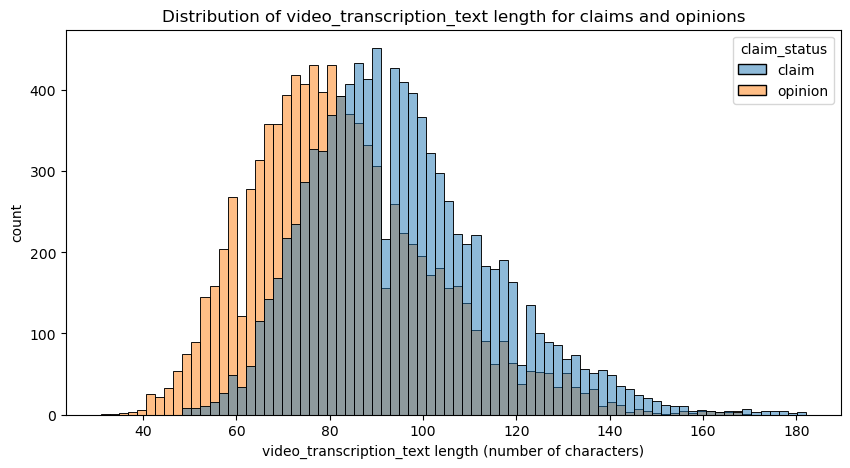

In [15]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot
plt.figure(figsize=(10,5))
sns.histplot(data = df_tiktok, x = 'text_length', hue= 'claim_status', alpha = .5, kde=False, legend=True)

plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("count")
plt.title("Distribution of video_transcription_text length for claims and opinions");

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about 13 more on average, as indicated in a previous cell.

Encode target and catgorical variables.

In [16]:
X = df_tiktok.copy()

In [17]:
# Drop unnecessary columns
X = X.drop(columns=['#', 'video_id'])

In [18]:
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})

In [19]:
# Dummy encode remaining categorical values
X = pd.get_dummies(data=X, columns=['verified_status', 'author_ban_status'], drop_first = True)

In [20]:
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


In [21]:
# Isolate target variable
y = X['claim_status']

In [22]:
# Isolate features
x = X.drop(columns=['claim_status'])

In [23]:
x.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


Split data into training and testing sets, 80/20.

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0 )

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [25]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=.25, random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [26]:
# Get shape of each training, validation, and testing set
x_tr.shape, x_val.shape, x_test.shape, y_tr.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

- The number of features (`11`) aligns between the training and testing sets.
- The number of rows aligns between the features and the outcome variable for training (`11,450`) and both validation and testing data (`3,817`).

### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [27]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

In [28]:
# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

In [29]:
# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [30]:
# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [31]:
x_tr_final = x_tr.drop(columns=['video_transcription_text'])

In [32]:
x_tr_final.shape

(11450, 10)

In [33]:
y_tr.shape

(11450,)

In [34]:
%%time
rf_cv.fit(x_tr_final, y_tr)

CPU times: user 5min 45s, sys: 1.95 s, total: 5min 47s
Wall time: 5min 53s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [35]:
# Examine best recall score
rf_cv.best_score_

0.9908534395531852

In [36]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

This model performs well, with an average recall score of 0.991 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

### **Build an XGBoost model**

In [37]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state =0)

In [38]:
# Create a dictionary of hyperparameters to tune
cv_params = { 'max_depth':[4,8,12], 'min_child_weight':[3,5],
             'learning_rate': [0.01,0.1], 'n_estimators': [300,500]

}

In [39]:
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [40]:
# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv = 5, refit='recall')

In [41]:
%%time
xgb_cv.fit(x_tr_final, y_tr)

CPU times: user 2min 41s, sys: 3.96 s, total: 2min 45s
Wall time: 44.8 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [42]:
xgb_cv.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [43]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

In [45]:
xgb_cv.best_score_

0.9898176171763818

This model also performs exceptionally well. Although its recall score is slightly lower than the random forest model's, its precision score is perfect.

### **Task 7. Evaluate models**

Evaluate models against validation data.

#### **Random forest**

In [49]:
x_val_final = x_val.drop('video_transcription_text', axis=1)

In [50]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(x_val_final)

In [51]:
# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [52]:
# Display the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

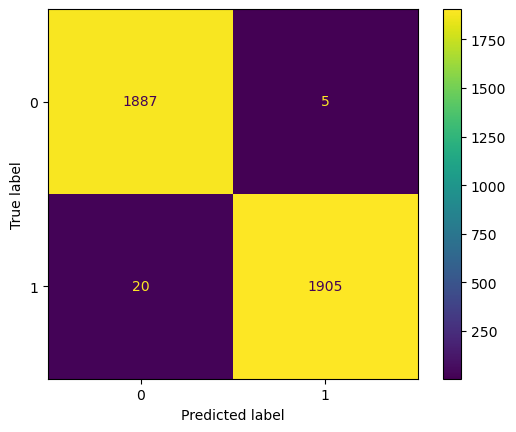

In [54]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix

log_cm = confusion_matrix(y_val, y_pred)
# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)
# Plot confusion matrix
log_disp.plot()
# Display plot
plt.show();

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model does not produce any false negatives.

In [55]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 25 misclassifications&mdash;five false postives and twenty false negatives.

In [56]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(x_val_final)

In [57]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

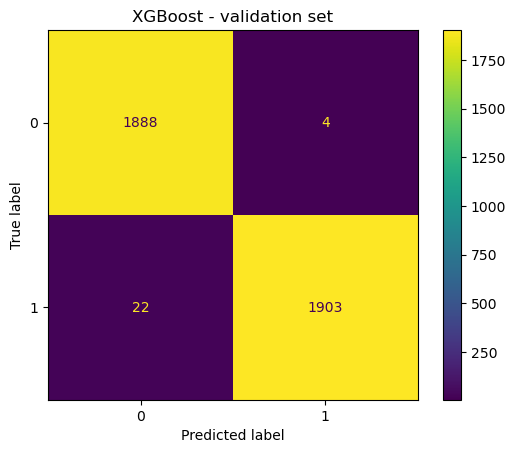

In [58]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()

In [59]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

In [64]:
x_test_final = x_test.drop(columns=['video_transcription_text'])

In [65]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(x_test_final)

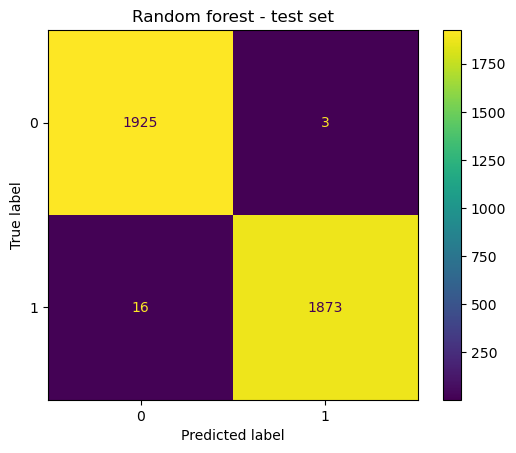

In [66]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

#### **Feature importances of champion model**

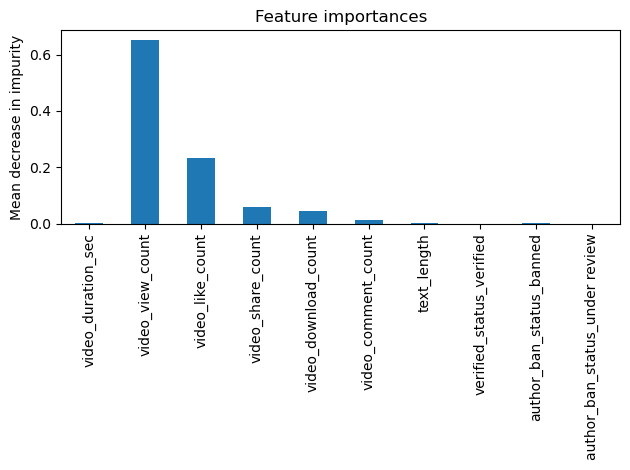

In [67]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=x_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.